In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [35]:
import os

h, w = 160, 160
x_test=[]

path_test_low='../../dataSets/test images/'

print('\nLoding Test dataset :')

i=0;
for img in os.listdir(path_test_low):
    img_low_path=os.path.join(path_test_low, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
    
    i=i+1
    print("{:.2f}".format(i/0.1)+' %',end='\r')
    
    x_test.append(img_low)

x_test=np.array(x_test, dtype="float32")


Loding Test dataset :


In [48]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2)),
                        (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def ssim(y_true, y_pred):
    return tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1))

def my_loss(y_true, y_pred):
    MAE_loss = K.mean(K.abs(y_pred - y_true))
    SSIM_loss = tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1))

    percent = 0.4
    index = int(h * w * percent - 1)
    gray1 = 0.39 * y_pred[:, :, :, 0] + 0.5 * y_pred[:, :, :, 1] + 0.11 * y_pred[:, :, :, 2]
    gray = tf.reshape(gray1, [-1, h * w])
    gray_sort = tf.nn.top_k(-gray, h * w)[0]
    yu = gray_sort[:, index]
    yu = tf.expand_dims(tf.expand_dims(yu, -1), -1)
    mask = tf.cast(gray1 <= yu,tf.float32)
    mask1 = tf.expand_dims(mask, -1)
    mask = tf.concat([mask1, mask1, mask1], -1)

    low_fake_clean = tf.multiply(mask, y_pred[:, :, :, :3])
    high_fake_clean = tf.multiply(1 - mask, y_pred[:, :, :, :3])
    low_clean = tf.multiply(mask, y_true[:, :, :, :])
    high_clean = tf.multiply(1 - mask, y_true[:, :, :, :])
    Region_loss = K.mean(K.abs(low_fake_clean - low_clean) * 4 + K.abs(high_fake_clean - high_clean))

    loss = MAE_loss + 3 - SSIM_loss + Region_loss
    
    return loss
def f(x):
    I = tf.math.add(0.29*x[:,:,:,0], tf.math.add(0.58*x[:,:,:,1], 0.11*x[:,:,:,2]))
    I = 1 - I
    I = tf.expand_dims(I , -1)
    return (tf.math.exp(I) - 1)/2.719

In [59]:
model=keras.models.load_model('../test/models/new.h5',custom_objects={'my_loss': my_loss,'ssim': ssim, 'f': f})

In [60]:
y_pred=model.predict(x_test)

def check_result(n):
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1).imshow(x_test[n])
    fig.add_subplot(1,2,2).imshow(y_pred[n])

# MBLLEN_1

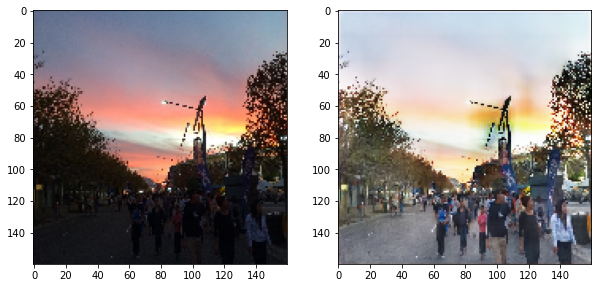

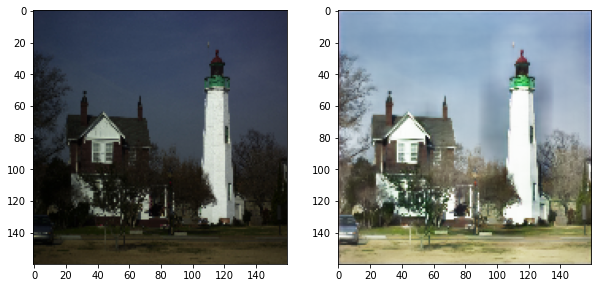

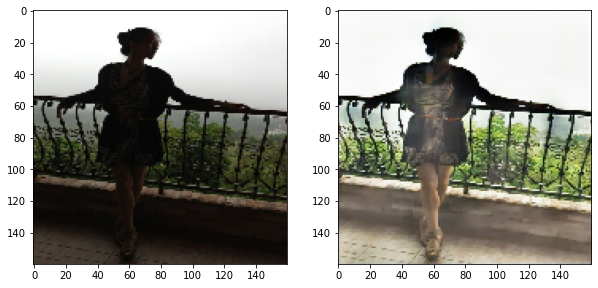

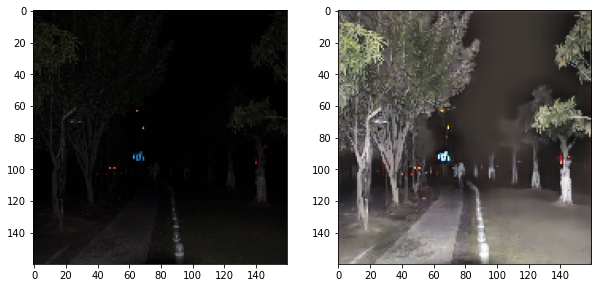

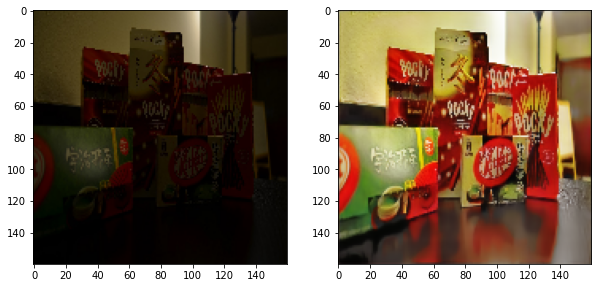

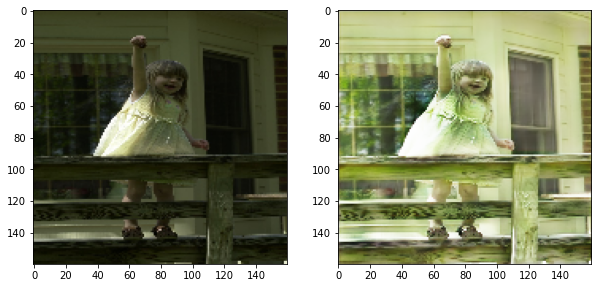

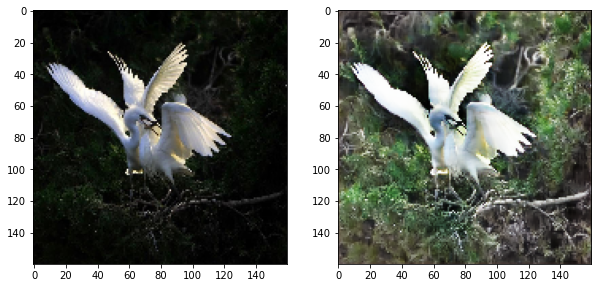

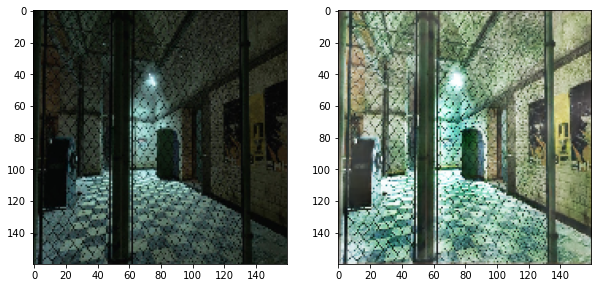

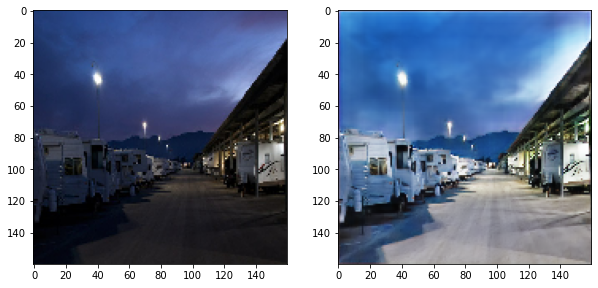

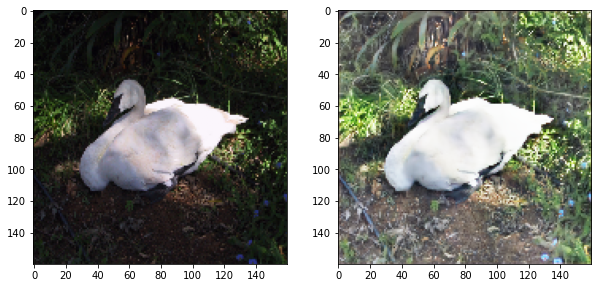

In [45]:
for i in range(10):
    check_result(i)

# MBLLEN_1_mod

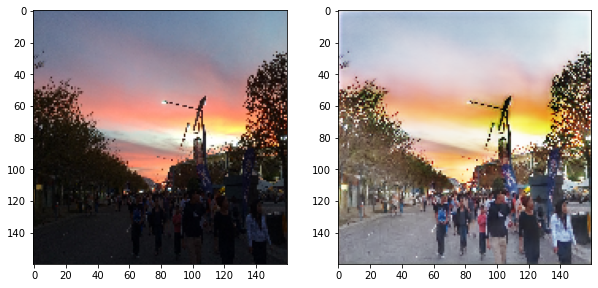

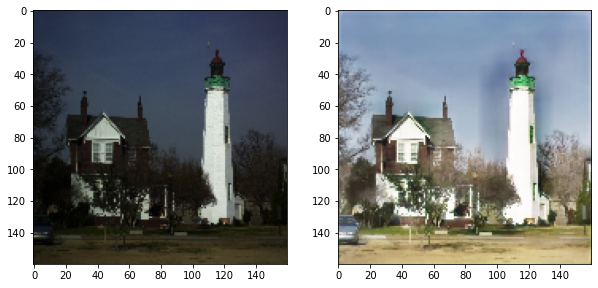

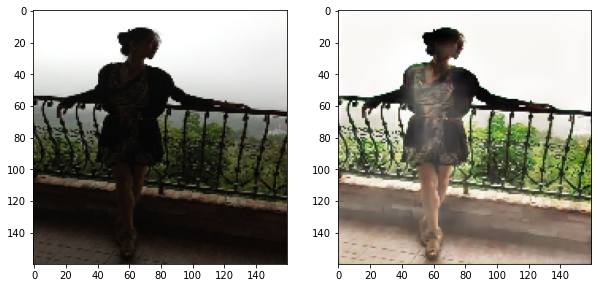

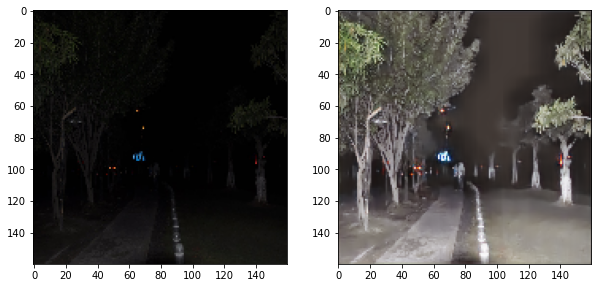

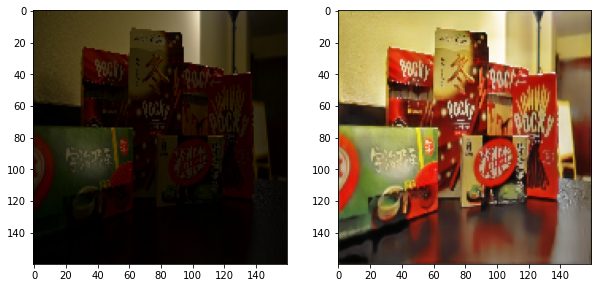

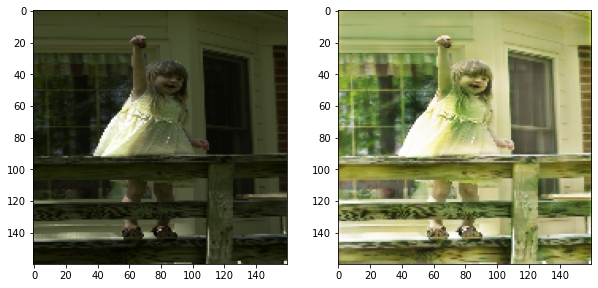

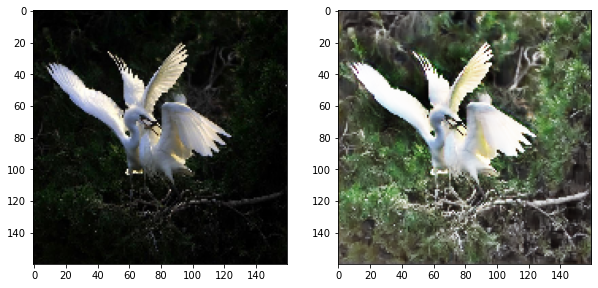

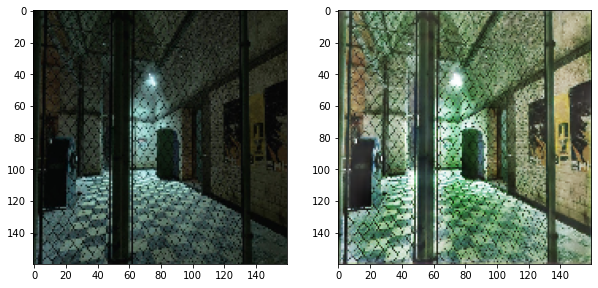

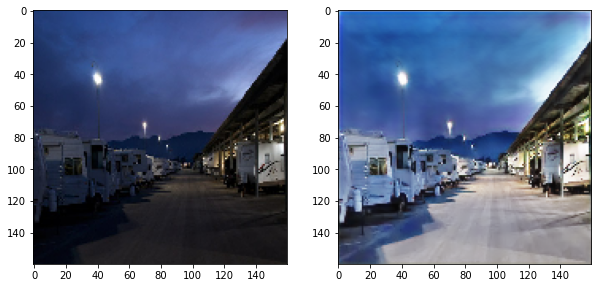

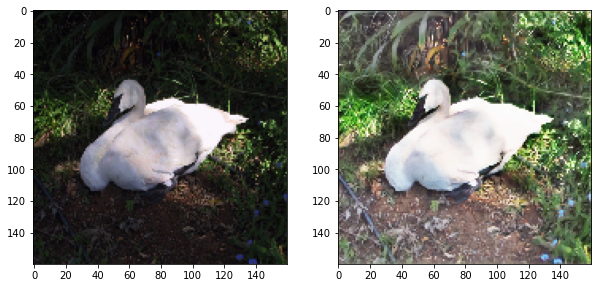

In [51]:
for i in range(10):
    check_result(i)

# new

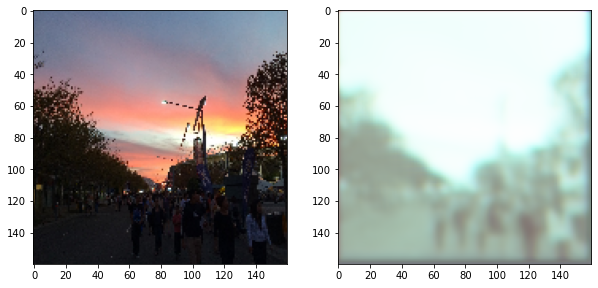

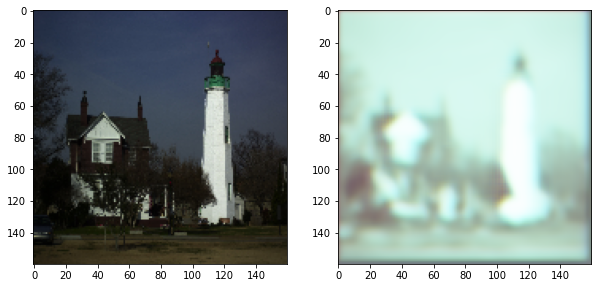

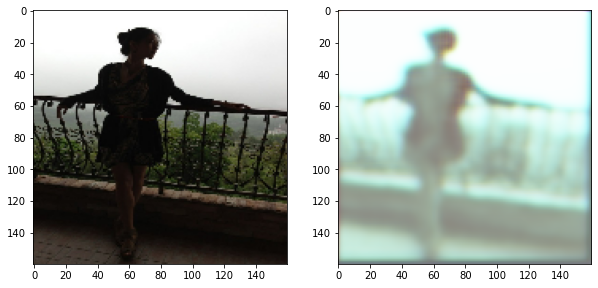

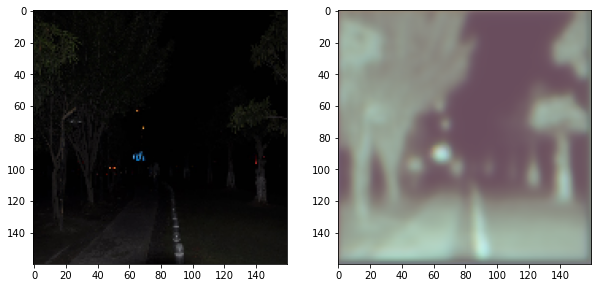

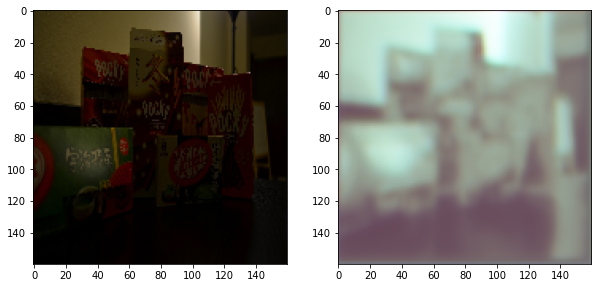

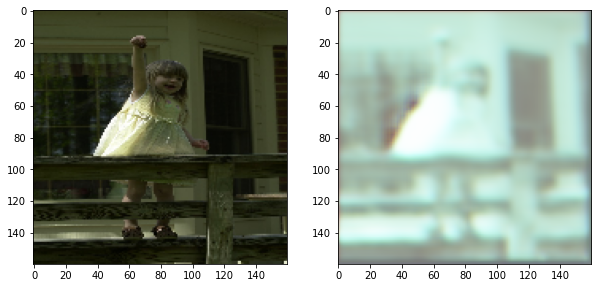

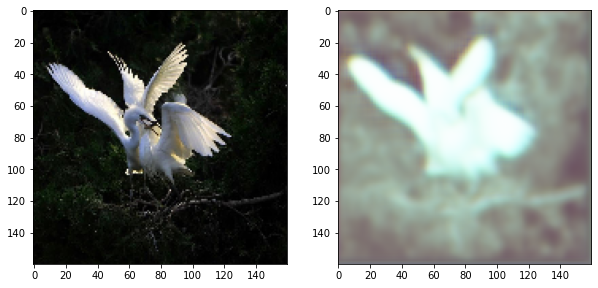

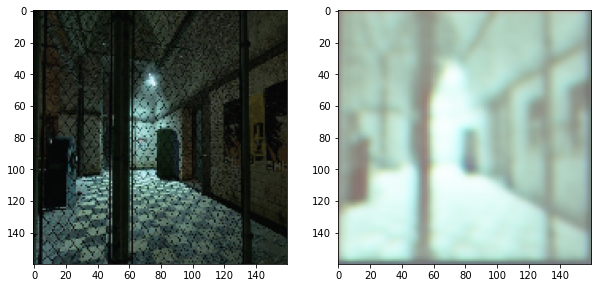

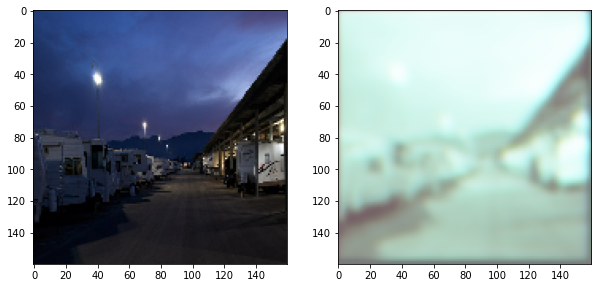

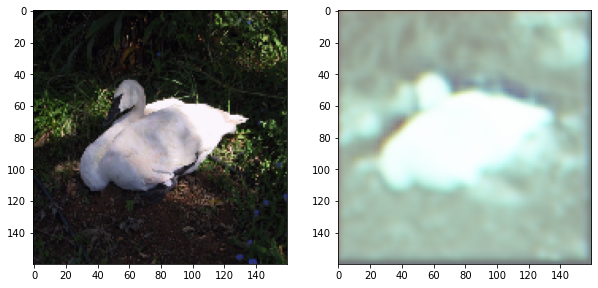

In [61]:
for i in range(10):
    check_result(i)